In [8]:
!pip install scikit-surprise

<b><u>Data Description</u>:</b> The repository has several
datasets. Here, we are using the Electronics
dataset.

<b><u>Domain</u>:</b>  E-commerce

<b><u>Context</u>:</b> Online E-commerce websites like Amazon, Flipkart uses
different recommendation models to provide different
suggestions to different users. Amazon currently uses
item-to-item collaborative filtering, which scales to massive
data sets and produces high-quality recommendations in
real-time.   

<b><u>Objective</u>:</b>  Build a personalised product recommendation system 

<b><u>Attribute Information </u> :</b>

Input variables:
##### Amazon Electronics Rating data:
1. UserId : Every user identified with a unique id
2. ProductId : Every product identified with a unique id
3. Rating : Rating of the corresponding product by the corresponding user
4. Timestamp : Time of the rating ( ignore this column for this exercise)
    
<b> <u>Learning Outcomes </u> :</b>
- Exploratory Data Analysis
- Creating a Recommendation system using real data
- Collaborative filtering

# :::::::::::::::::::::::::::::::::::::Steps and tasks::::::::::::::::::::::::::::::::::::::::::::

##  Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)

### => Import the necessary libraries :

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

from scipy.stats import skew


<b>Comment :</b>
- Here We have used numpy, pandas, matplotlib, seaborn for EDA and Data Visualization.
- Surprise library for data spliting, model building and for accuracy.
- GridSearchCV to find the best parameters.

# ::--------------------------- Exploratory Data Analysis -------------------------------- ::

### => Read the data as a dataframe :-

In [11]:
df = pd.read_csv("/kaggle/input/amazon-electronics-rating-datasetrecommendation/ratings_Electronics.csv", names=["userId", "productId", "rating", "timestamp"])
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


<b>Comment:</b> Here We have read the Ratings Data using read_csv() function of pandas. df is a dataframe. I have used head() funtion to display first 5 records of the dataset.

### => Shape of the data :-

In [12]:
rows_count, columns_count = df.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 7824482
Total Number of columns : 4


<b>Comment:</b>
There are 7824482 rows and 4 columns in the dataset.

### => Data type of each attribute :-

In [13]:
df.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

<b>Comment:</b> By displaying the datatypes of each variable we can see the following:

   -  int type           :  rating, timestamp
   -  object type(string):  userId, productId



### => Unique UserId and ProductID :-

In [14]:
unique_userId = df['userId'].nunique()
unique_productId = df['productId'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  4201696
Total number of unique Products :  476002


### => Checking the presence of missing values :-

In [15]:
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [16]:
df.isna().any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

<b>Comment:</b> From above we can see that there are no missing values present in the dataset which are checked by using isnull() and isna() functions.

### =>  Data Characteristics :-

In [17]:
df_transpose = df.describe().T
df_transpose

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


-1.2053969554814676

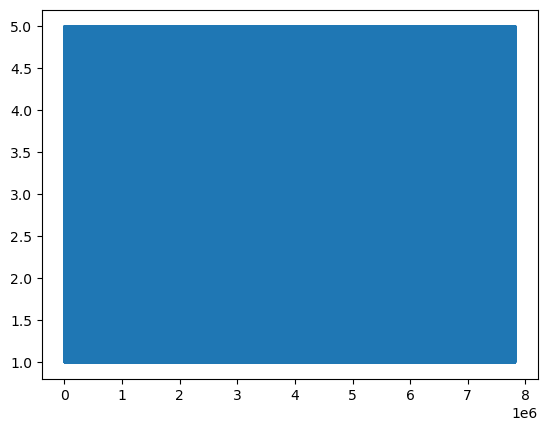

In [18]:
plt.plot(df['rating'])
skew(df['rating'])

-1.9218296481863602

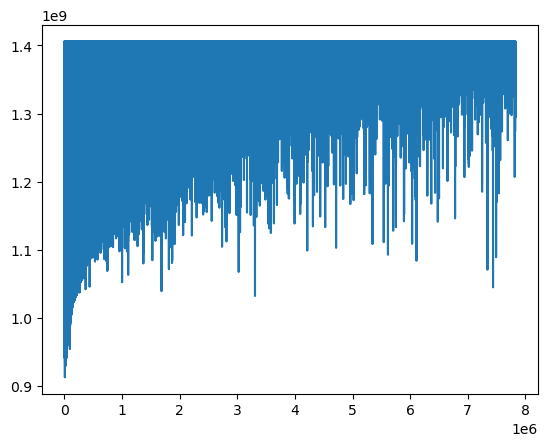

In [19]:
plt.plot(df['timestamp'])
skew(df['timestamp'])

<b>Comment : </b>  From above we can see that
- Mean of rating is less than median which stats that the distribution is negatively skewed.
- Mean of timestamp is almost near to median which stats the distribution is symmetric.

### =>  Five point summary of  numerical attributes  :-

In [20]:
df_transpose[['min', '25%', '50%', '75%', 'max']]

,min,25%,50%,75%,max
rating,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


### => Checking the presence of outliers :-

<Axes: >

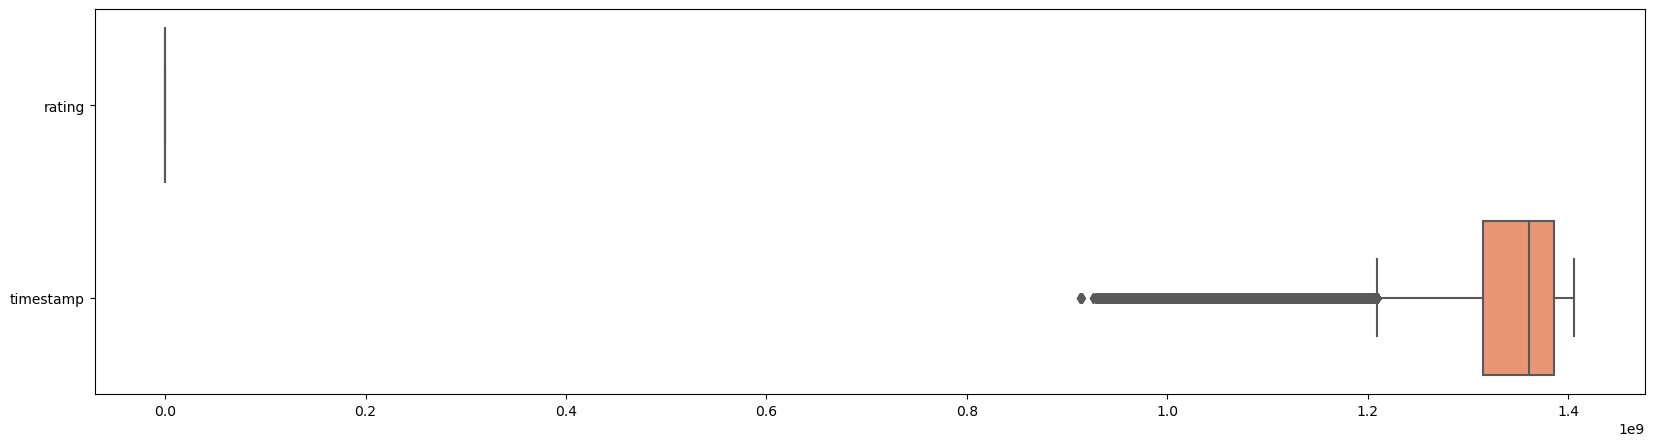

In [21]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, orient='h', palette='Set2', dodge=False)

<b>Observation : </b> From the above boxplot we can see that there are outliers in timestamp column. But since we are not considering the timestamp we are not fixing the outliers

# ::-------------------------------------- Data Visualization ------------------------------------::

### =>  Pair plot that includes all the columns of the data frame :-

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


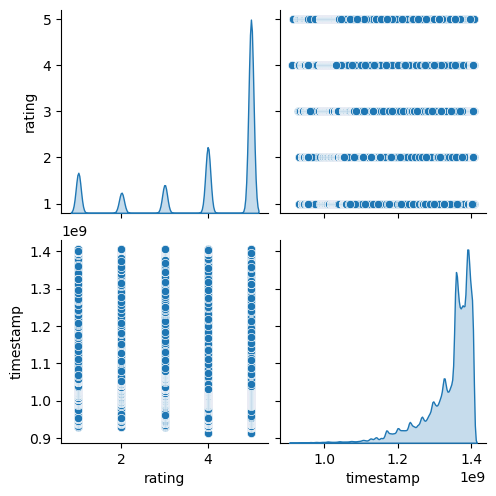

In [22]:
sns.pairplot(df, diag_kind= 'kde')

<b> Comment : </b> From above we can see there is tall tower of 5 rating which stats that most of the customers have given 5 rating. Very less customers have given 2 rating. From here we can infer that most of the electronics products are liked by the customers.

### => Checking the ratio of all 5 ratings

In [23]:
df['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

In [24]:
rating_counts = pd.DataFrame(df['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5.0,4347541
1,4.0,1485781
2,1.0,901765
3,3.0,633073
4,2.0,456322


<b>Comment:</b> Number of 1 ratings in our dataset are high compared to other ratings, indicating number of people who have given 1 rating to the products are high.
Below code shows the ratio among them.

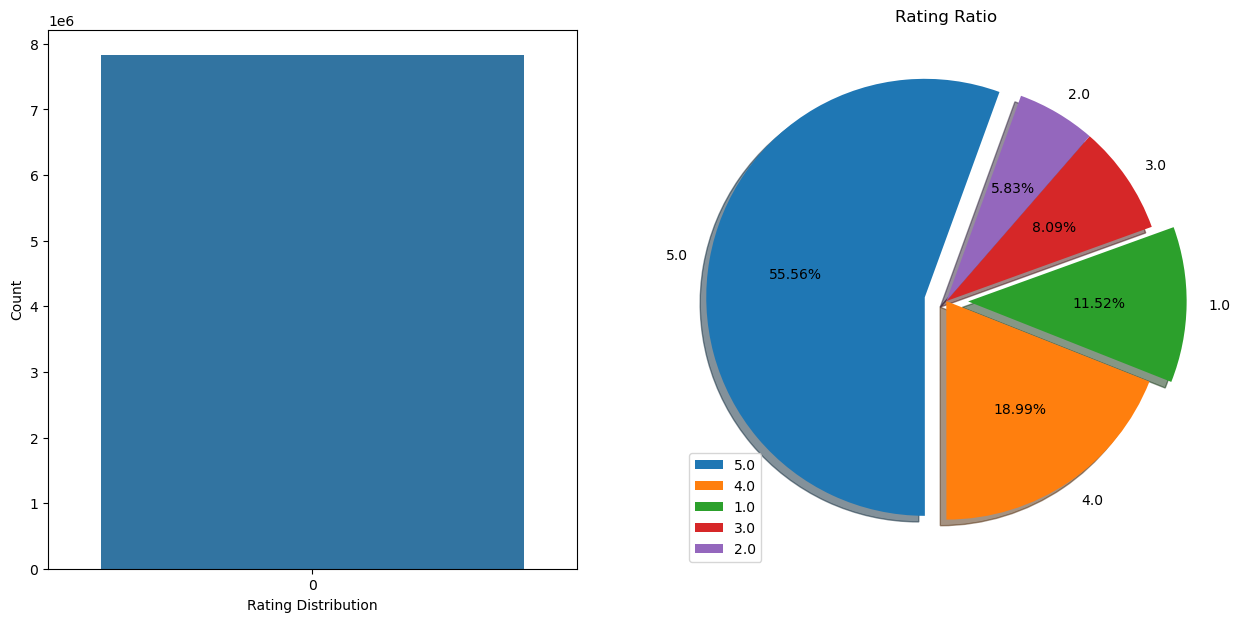

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(df['rating'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

<b>Observation :</b> From the barplot and pie chart, we can infer that approx 55% of data have 5 rating followed by 4(approx 19%). Least number of people have given 2 rating. One important insight from here is that most of the products are liked by the customers.   

### => Creating and viewing the correlation matrix :-

In [26]:
df.corr()

/tmp/ipykernel_32/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,rating,timestamp
rating,1.000000,0.041648
timestamp,0.041648,1.000000


/tmp/ipykernel_32/273955916.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr(), dtype=np.bool)
/tmp/ipykernel_32/273955916.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)
/tmp/ipykernel_32/273955916.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warnin

<Axes: title={'center': 'Correlation of Attributes'}>

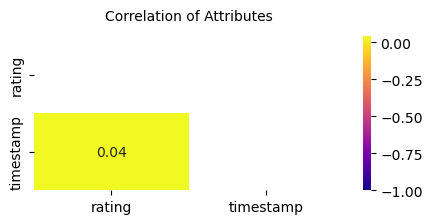

In [27]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,2))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(df.corr(),vmin=-1, cmap='plasma',annot=True,  mask=mask, fmt='.2f')

<b>Comment : </b> We won't find any high correlation between rating and timestamp as we do not have many attributes.

#### Dropping timestamp :-

In [28]:
df = df.drop(['timestamp'], axis=1)

I have copied the dataframe df to df1 before doing any modifications to the dataset so as to save loading time.


In [29]:
df1 = df.copy()

In [30]:
df1.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


# Taking a subset of the dataset to make it less sparse/ denser.( For example, take the users only who has given 50 or more number of ratings ) ::-

#### => Taking Subset of users who have given 50 or more number of ratings :-

In [31]:
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),left_on='userId',right_index=True)

In [32]:
subset_df = users_data[users_data.users_counts >= 50]
subset_df.head()

,userId,productId,rating,users_counts
94,A3BY5KCNQZXV5U,0594451647,5.0,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


<b>Comment : </b> We have filtered out the users  who have given 50 or more number of ratings to ensure that our analysis is focused on users who have actively engaged with a significant number of ratings, thereby enhancing the robustness and reliability of insights.

#### => Taking Subset of products which have received 10 or more number of ratings to overcome the Grey Ship problem :-

In [33]:
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),left_on='productId',right_index=True)

In [34]:
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,rating,users_counts,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,65,18


<b>Important : </b>In our analysis, we are focusing on products that have received atleast 10 ratings. This filtering criterion is vital as it helps us address situations where a product might have only one or two ratings, yet these ratings are high (e.g., 5). Under such circumstances, these products could disproportionately dominate the top recommendations, leading to less effective recommendation outcomes. By setting a threshold of 10 ratings, we aim to ensure a more reliable and balanced recommendation approach.

In [35]:
amazon_df = product_rating_data.copy()

In [36]:
panda_data = amazon_df.drop(['users_counts', 'product_rating_counts'], axis=1)

In [37]:
panda_data.head()

,userId,productId,rating
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0


## Spliting the data randomly into train and test dataset. (Split it in 70/30 ratio) ::-

To load the dataset from a pandas dataframe, we will need the load_from_df() method and also reader object which we have already declared.

To Get top - K ( K = 5) recommendations I am initalizing k below.

In [38]:
k = 5

We need to define a Reader object for Surprise to be able to parse the dataframe.

In [39]:
reader = Reader(rating_scale=(1, 5))

In [40]:
surprise_data = Dataset.load_from_df(panda_data[['userId', 'productId', 'rating']], reader)

In [41]:
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

# Building Popularity Recommender model ::-

In two ways, we will be creating this Recommender model.
- Using mean of product ratings
- Using Ranking Based Algorithm

## =>  Using mean of products rating :-

In [42]:
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [43]:
panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00HG1L334    5.0
B001TH7GUA    5.0
B00C20KWP4    5.0
B004Y1AYAC    5.0
Name: rating, dtype: float64

In [44]:
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())
prod_rating_count.head(k)

,rating,prod_rating_count
productId,,
B00L3YHF6O,5.0,14
B00HG1L334,5.0,16
B001TH7GUA,5.0,17
B00C20KWP4,5.0,10
B004Y1AYAC,5.0,11


In [45]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

,rating,prod_rating_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


<b>Comment : </b> Above is the list of top 5 popular products for the recommendation.

## => Ranking-Based Algorithms  :-

Creating a Product recommender :-

Building Popularity Recommender model(Non-personalised) :-

In [46]:
#Count of user_id for each unique song as recommendation score
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped.head()


,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [47]:
#Sort the songs on recommendation score
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

#Generate a recommendation rank based upon score
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first')

#Get the top 5 recommendations
popularity_recommendations = panda_data_sort.head(k)
popularity_recommendations

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0


#### Using popularity based recommender model to make predictions and find recommendations for random list of users with inferences

In [48]:
# UsINNG popularity based recommender model to make predictions
import warnings
warnings.filterwarnings('ignore')
def recommend(userId):
    user_recommendations = popularity_recommendations

    #Adding user_id column for which the recommendations are being generated
    user_recommendations['userID'] = userId

    #Bringing user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [49]:
find_recom = [15,121,55,230,344]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

Here is the recommendation for the userId: 15

      userID   productId  score  Rank
1592      15  B0088CJT4U    206   1.0
839       15  B003ES5ZUU    184   2.0
226       15  B000N99BBC    167   3.0
1552      15  B007WTAJTO    164   4.0
1577      15  B00829TIEK    149   5.0


Here is the recommendation for the userId: 121

      userID   productId  score  Rank
1592     121  B0088CJT4U    206   1.0
839      121  B003ES5ZUU    184   2.0
226      121  B000N99BBC    167   3.0
1552     121  B007WTAJTO    164   4.0
1577     121  B00829TIEK    149   5.0


Here is the recommendation for the userId: 55

      userID   productId  score  Rank
1592      55  B0088CJT4U    206   1.0
839       55  B003ES5ZUU    184   2.0
226       55  B000N99BBC    167   3.0
1552      55  B007WTAJTO    164   4.0
1577      55  B00829TIEK    149   5.0


Here is the recommendation for the userId: 230

      userID   productId  score  Rank
1592     230  B0088CJT4U    206   1.0
839      230  B003ES5ZUU    184   2.0
226   

<b>Comment : </b> Top 5 popular products(B0088CJT4U, B003ES5ZUU, B000N99BBC, B007WTAJTO, B00829TIEK).
- Since this is a popularity-based recommender model, recommendations remain the same for all users. Here, products are recommended based on the popularity and is not personalized to particular user.

## Building Collaborative Filtering model ::-

For the Collaborative Filtering Model I am going to use <b>SVD, KNNWithMeans </b> and we will also test with other algorithms

In [56]:
cv_results = []  # to store cross validation result

# ------------------------Matrix Factorization Based Algorithms------------------------------

### => Grid Search :-

Here we are using grid search to find out the best hyper parameters for SVD and SVDpp Algorithms.
- n_epochs values : [20, 25]
- lr_all          : [0.007, 0.009, 0.01]
- reg_all         : [0.4, 0.6]

In [54]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

0.8700667243555907
0.8714514394287587
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


<b>Comment : </b> Above we have found the best parameters for the SVD an SVDpp algorithms and we will pass these parameters while creating model.

### =>  SVD :-

In [55]:
import time as time

In [60]:
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'],
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8844  0.8708  0.8664  0.8659  0.8894  0.8754  0.0097  
MAE (testset)     0.6521  0.6427  0.6387  0.6435  0.6539  0.6462  0.0059  
Fit time          0.60    0.59    0.58    0.59    0.73    0.62    0.06    
Test time         0.10    0.09    0.10    0.09    0.10    0.10    0.00    


==================== Model Evaluation ===============================
RMSE: 0.8806

 Computational Time : 4.948s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399


<b> Comment :</b> Here we can see that the RMSE of testset and complete dataset found from cross_validation is almost same, which implies our model is performing well on trainset and testset.

### => SVD++ :-

In [61]:
start_time = time.time()

# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)


# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'],
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8763  0.8713  0.8607  0.8721  0.8807  0.8722  0.0067  
MAE (testset)     0.6431  0.6452  0.6335  0.6476  0.6510  0.6441  0.0059  
Fit time          6.43    6.44    6.51    6.49    6.55    6.49    0.05    
Test time         0.88    0.67    0.69    0.64    0.67    0.71    0.09    


==================== Model Evaluation ===============================
RMSE: 0.8770

 Computational Time : 42.466s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399
1,SVDpp,0.872212,0.644093,6.485837,0.708757


# ---------------------------------- k-NN Based Algorithms ----------------------------------------

### => Grid Search :-

Here we are using grid search to find out the best hyper parameters for <b>KNNBasic</b>, <b>KNNWithMeans</b> and <b>KNNWithZScore<b/> Algorithms.

In [62]:
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_

### => KNNBasic :-

In [63]:
start_time = time.time()

# Creating Model using best parameters
knnBasic_model = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'],
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9699  0.9945  0.9698  0.9760  0.9896  0.9800  0.0102  
MAE (testset)     0.6855  0.7059  0.6880  0.6976  0.7029  0.6960  0.0080  
Fit time          0.42    0.38    0.34    0.34    0.34    0.36    0.03    
Test time         0.68    0.61    0.60    0.60    0.69    0.64    0.04    


==================== Model Evaluation ===============================
RMSE: 1.0018

 Computational Time : 6.

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399
1,SVDpp,0.872212,0.644093,6.485837,0.708757
2,KNNBasic,0.979959,0.695969,0.361383,0.636950


### => KNNWithZScore :-

In [64]:
start_time = time.time()

# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'],
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9236  0.9272  0.9265  0.9462  0.9366  0.9320  0.0083  
MAE (testset)     0.6457  0.6481  0.6485  0.6578  0.6517  0.6503  0.0042  
Fit time          0.58    0.49    0.58    0.60    0.49    0.55    0.05    
Test time         0.69    0.69    0.77    0.91    0.66    0.75    0.09    


==================== Model Evaluation ===============================
RMSE: 0.9541

 Computational Time

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399
1,SVDpp,0.872212,0.644093,6.485837,0.708757
2,KNNBasic,0.979959,0.695969,0.361383,0.636950
3,KNNWithZScore,0.932011,0.650350,0.549606,0.746408


### => KNNWithMeans User-User

In [65]:
start_time = time.time()

# Creating Model using best parameters
knnMeansUU_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(trainset)

# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'],
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansUU, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9147  0.9103  0.9221  0.9262  0.9090  0.9165  0.0067  
MAE (testset)     0.6462  0.6364  0.6436  0.6477  0.6431  0.6434  0.0039  
Fit time          0.18    0.16    0.15    0.15    0.21    0.17    0.02    
Test time         0.48    0.50    0.50    0.50    0.54    0.50    0.02    


==================== Model Evaluation ===============================
RMSE: 0.9364

 Computational Time 

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399
1,SVDpp,0.872212,0.644093,6.485837,0.708757
2,KNNBasic,0.979959,0.695969,0.361383,0.636950
3,KNNWithZScore,0.932011,0.650350,0.549606,0.746408
4,KNNWithMeans User-User,0.916456,0.643397,0.169881,0.504680


### => KNNWithMeans Item-Item

In [66]:
# Creating Model using best parameters
knnMeansII_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnMeansII_model.fit(trainset)

# Predicting for testset
prediction_knnMeansII = knnMeansII_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans Item-Item on 5 split(s)
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'],
                           knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansII_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansII, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9287  0.9166  0.9185  0.9145  0.9292  0.9215  0.0062  
MAE (testset)     0.6493  0.6421  0.6515  0.6433  0.6522  0.6477  0.0042  
Fit time          0.36    0.37    0.37    0.37    0.36    0.37    0.00    
Test time         0.66    0.63    0.96    0.67    0.66    0.72    0.12    


==================== Model Evaluation ===============================
RMSE: 0.9450

 Computational Time 

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399
1,SVDpp,0.872212,0.644093,6.485837,0.708757
2,KNNBasic,0.979959,0.695969,0.361383,0.636950
3,KNNWithZScore,0.932011,0.650350,0.549606,0.746408
4,KNNWithMeans User-User,0.916456,0.643397,0.169881,0.504680
5,KNNWithMeans Item-Item,0.921479,0.647687,0.365150,0.715958


Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
D

## ----------------------------- Comparison of all algorithms on RMSE and MAE ------------------------

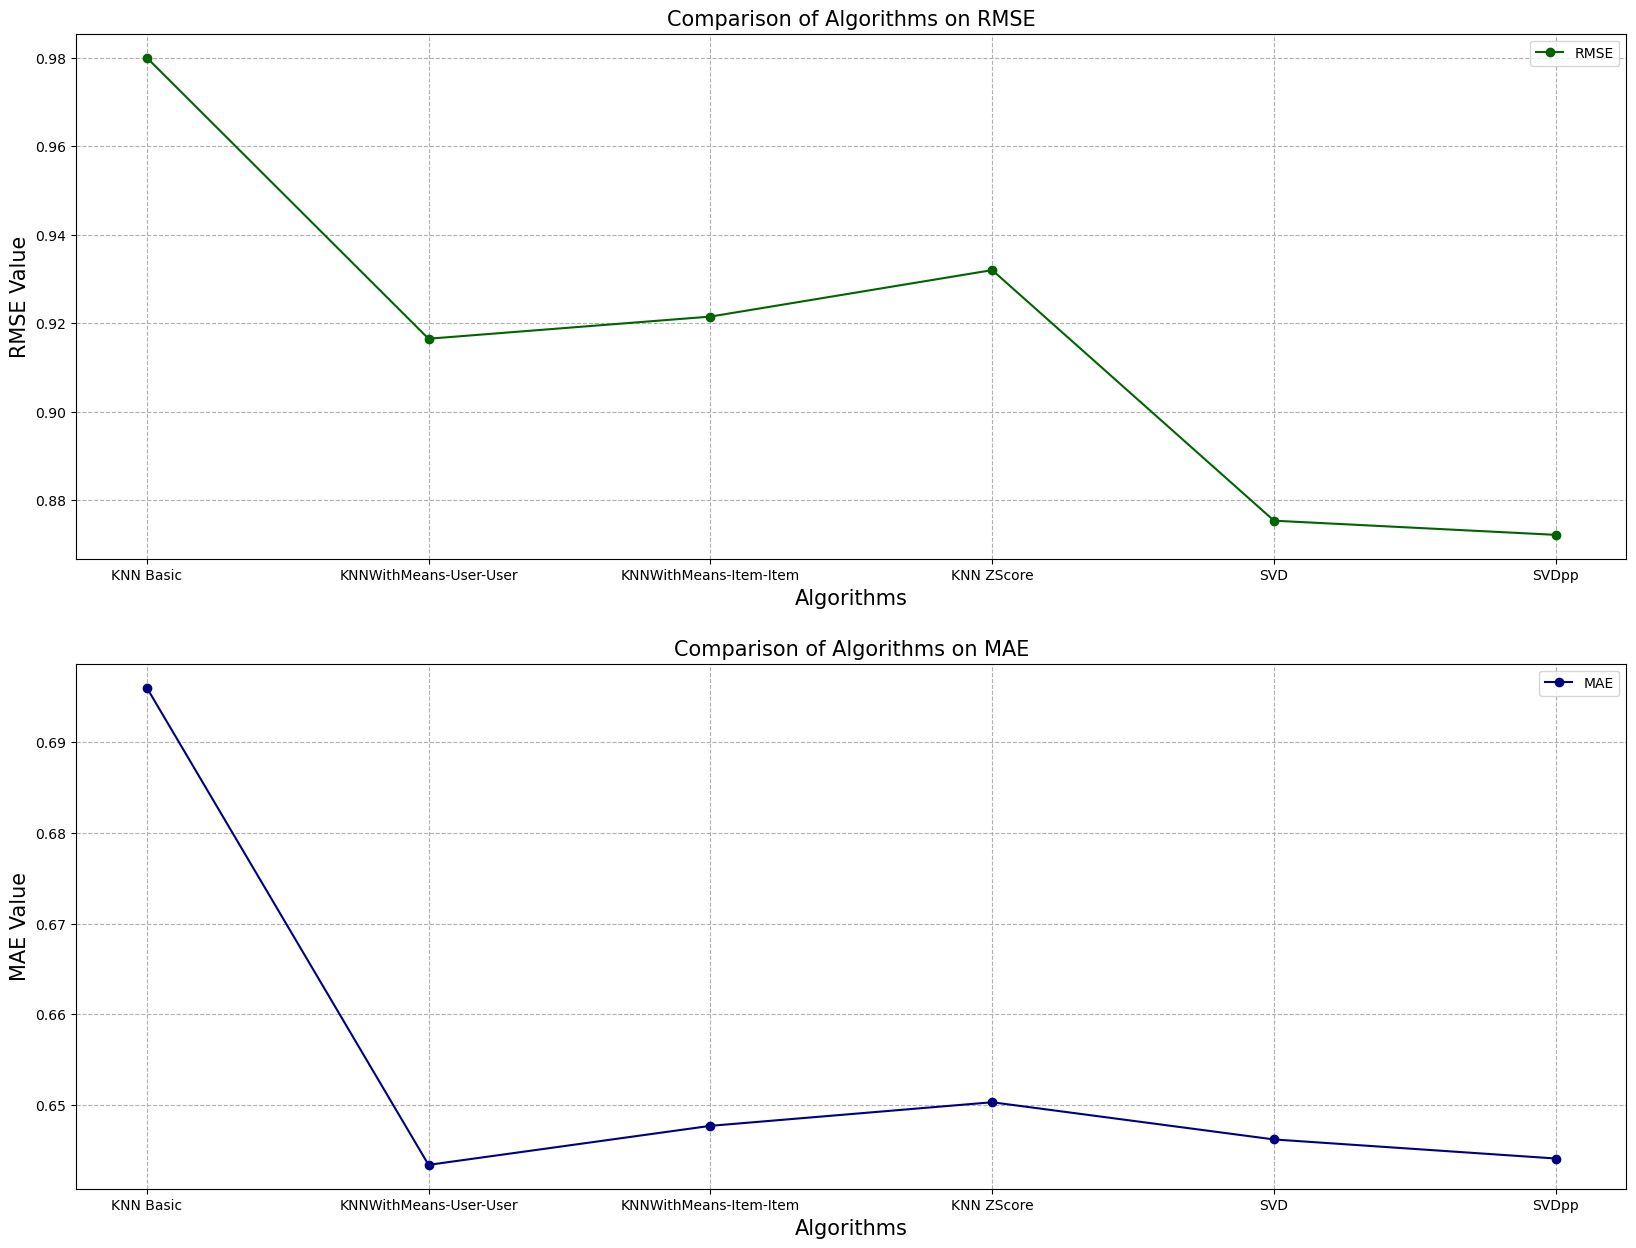

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875372,0.646193,0.616793,0.096399
1,SVDpp,0.872212,0.644093,6.485837,0.708757
2,KNNBasic,0.979959,0.695969,0.361383,0.636950
3,KNNWithZScore,0.932011,0.650350,0.549606,0.746408
4,KNNWithMeans User-User,0.916456,0.643397,0.169881,0.504680
5,KNNWithMeans Item-Item,0.921479,0.647687,0.365150,0.715958


In [67]:
x_algo = ['KNN Basic', 'KNNWithMeans-User-User', 'KNNWithMeans-Item-Item', 'KNN ZScore', 'SVD', 'SVDpp']
all_algos_cv = [knnBasic_cv, knnMeansUU_cv, knnMeansII_cv, knnZscore_cv, svd_cv, svdpp_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,15))

plt.subplot(2, 1, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(2, 1, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

cv_results

## Evaluation Results :-

From the comparison plots of the algorithms above, we can infer the following conclusions:
- RMSE : SVD++ is giving the best RMSE value with parameters {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4} and SVD is giving the second best RMSE with parameters {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
- MAE : Here SVD++ and KNNWithMeans both are giving the best MAE value.
- Svd++ is having the best RMSE in Matrix Factorization Based Algorithms.
- KNNWithMeans is giving the best RMSE in Collaborative Filtering Algorithms.
- <b> Note : </b> When comparing SVD and SVD++, we can notice that the Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) values of SVD exhibit slight differs from those of SVD++. But SVD outperforms SVD++ in terms of computational efficiency, with significantly lower fit times and test times (approximately 12 times faster). Given this advantage in terms of speed, we've decided to proceed with SVD to generate our top-k recommendations.



## top - K ( K = 5) recommendations ::-

- Here I am using SVD algorithm to get the top 5 recommendations of new products for each user.

In [68]:
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list,
            {'AZBXKUH4AIW3X': [('B008EQZ25K', 4.764070326467216),
              ('B005LDLP8W', 4.754673309745342),
              ('B0058UUR6E', 4.747210227916162),
              ('B00029U1DK', 4.652394274753916),
              ('B00316263Y', 4.642590476047388)],
             'A1T1YSCDW0PD25': [('B004S4R5CK', 4.902046748276052),
              ('B0002SQ2P2', 4.801317147649189),
              ('B0099SMFVQ', 4.800583059430887),
              ('B000CKVOOY', 4.792874018396889),
              ('B000AZ57M6', 4.724475030200603)],
             'A1HYH206E18XVC': [('B006EKIQYM', 4.549021821643326),
              ('B00CE590Z0', 4.3250087013464515),
              ('B003YKG2UK', 4.230476005604847),
              ('B005DM9BGE', 4.230300995888261),
              ('B002VPE1XY', 4.043311570595834)],
             'A2ZFFSJ0VM6KSJ': [('B00AAIPT76', 4.925672388628066),
              ('B005DOK8NW', 4.8211993965539515),
              ('B00CDS9HTM', 4.732257055014549),
              ('B008AST7

<b> Comment : </b> From the above list we can see that model is making top 5 product recommendations to each user. There are some instances where it recommends less than 5 products. It is due to model's inability to locate an appropriate number of neighboring items for certain cases.

### => Precision and recall at k=5

In [69]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


kf = KFold(n_splits=5)
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
precs = []
recalls = []

for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print('Precision : ', sum(prec for prec in precisions.values()) / len(precisions))
    print('recalls : ',sum(rec for rec in recalls.values()) / len(recalls))


Precision :  0.8710973370064261
recalls :  0.8289836886228237
Precision :  0.8714708561020027
recalls :  0.8337567592140148
Precision :  0.8731999079825151
recalls :  0.8295828804476383
Precision :  0.8759527089072525
recalls :  0.8301596624810037
Precision :  0.8696180555555537
recalls :  0.8281596041875362


<b>Comment : </b> We have computed Precision and Recall at k=5 to evaluate recommendation system. Precision and Recall are used as binary metrics for assessing models with binary outcomes. To align this problem, where ratings usually span from 1 to 5, with this binary evaluation, we've employed an approach. In this approach, we've categorized any true rating above 3.5 as indicative of a <b>relevant</b> item, while any true rating below 3.5 is considered as indicative of an <b>irrelevant</b> .

- My precision at 5 in a top-5 recommendation problem is almost 87% indicating that 87% of the provided   recommendations align with users' preferences and needs..
- My recall at 5 in a top-5 recommendation problem is almost 83%. This signifies that out of the
  complete set of relevant products, 83% of them are successfully captured within the top-k 
  recommendations.

In [70]:
average_precision = sum(prec for prec in precisions.values()) / len(precisions)
average_recall = sum(rec for rec in recalls.values()) / len(recalls)


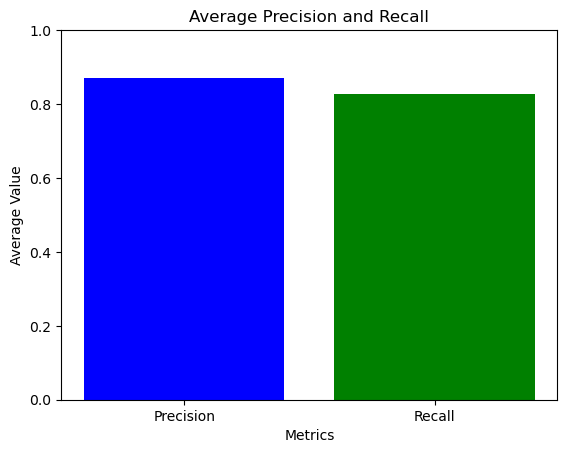

In [71]:
# Create a bar plot for precision and recall
labels = ['Precision', 'Recall']
values = [average_precision, average_recall]

plt.bar(labels, values, color=['blue', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Average Precision and Recall')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for precision and recall
plt.show()

In [93]:

#Calculate the density of the rating matrix

final_ratings_matrix = subset_df.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [94]:
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = subset_df.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
pivot_df.shape
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [77]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [80]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [82]:

def recommend_items(userId, pivot_df, preds_df, num_recommendations):
      
    user_idx = userId-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [85]:
#Enter 'userId' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.524522
B00829TIEK                  0.0          1.335672
B000N99BBC                  0.0          1.262374
B008DWCRQW                  0.0          1.062069
B004CLYEDC                  0.0          1.014894


In [86]:
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [87]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [96]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [97]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



In [98]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.524522
B00829TIEK                  0.0          1.335672
B000N99BBC                  0.0          1.262374
B008DWCRQW                  0.0          1.062069
B004CLYEDC                  0.0          1.014894


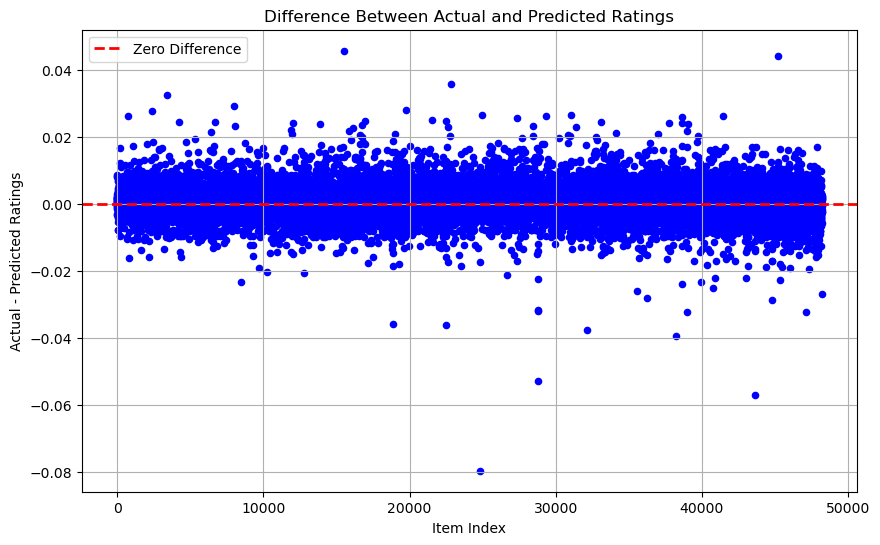

In [100]:

# Assuming rmse_df is already defined

# Calculate the difference between actual and predicted ratings
rmse_df['Rating_Difference'] = rmse_df['Avg_actual_ratings'] - rmse_df['Avg_predicted_ratings']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(rmse_df['item_index'], rmse_df['Rating_Difference'], color='b', marker='o', s=20)
plt.axhline(0, color='r', linestyle='--', linewidth=2, label='Zero Difference')
plt.xlabel('Item Index')
plt.ylabel('Actual - Predicted Ratings')
plt.title('Difference Between Actual and Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()